In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *
from functions.find_bubbles import *
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Redistributional consequences of asset price bubbles
*In other words: Who wins and who loses*

To find out, I simulate the model first.

In [2]:
NRUNS = 1
input_parameters = [0.29985649, 37.20189844, 74.72231157, 11.65898537,  0.73132061, 0.30623129,  0.57451773]
burn_in_period = 400 
labels = ['std_noise', 'w_fundamentalists', 'w_momentum', 'base_risk_aversion', "fundamentalist_horizon_multiplier",
                          "mutation_probability", "average_learning_ability"]

uncertain_parameters = dict(zip(labels, input_parameters))
params = {"ticks": 1200 + burn_in_period, "fundamental_value": 166, 'n_traders': 500, 'std_fundamental': 0.0530163128919286,
                  'spread_max': 0.004087, "w_random": 1.0, "init_stocks": 50, 'trader_sample_size': 19,
                  'horizon': 200, "trades_per_tick": 5}  # TODO make ticks: 600 * 10
params.update(uncertain_parameters)
#

In [3]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

('Start of simulation ', 0)


To study the redistributional effects of bubbles, I first find bubble periods.

In [4]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs, burn_in_period=burn_in_period)
y = pd.Series(mc_prices[0][:-1] / mc_fundamentals[0])

Text(0.5,0,'Simulation time')

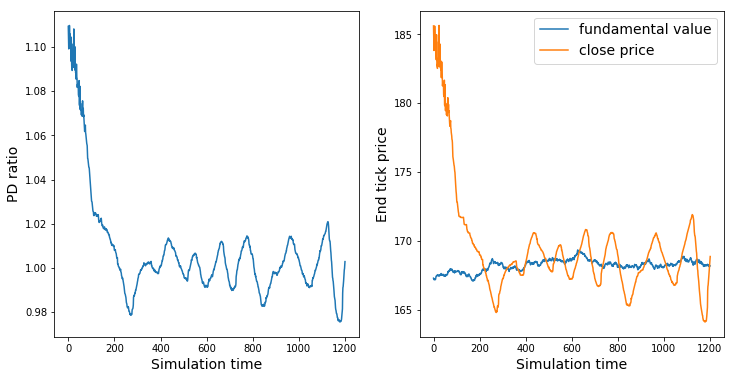

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

#ax1.plot(mc_returns.index, mc_returns[1], label='returns')
ax1.plot(y.index, y, label='returns')

ax1.set_xlabel('Simulation time', fontsize='14')
ax1.set_ylabel('PD ratio', fontsize='14')

ax2.plot(mc_fundamentals.index, mc_fundamentals[0], label='fundamental value')
ax2.plot(mc_prices.index, mc_prices[0], label='close price')

ax2.set_ylabel('End tick price', fontsize='14')
ax2.legend(loc='best', fontsize='14')
ax2.set_xlabel('Simulation time', fontsize='14')

In [6]:
obs = len(y)
r0 = 0.01 + 1.8/np.sqrt(obs)
swindow0 = int(math.floor(r0*obs))
dim = obs - swindow0 + 1
IC = 2
adflag = 6
yr = 2
Tb = 12*yr + swindow0 - 1
nboot = 99

bsadfs = PSY(y, swindow0, IC, adflag)
quantilesBsadf = cvPSYwmboot(y, swindow0, IC, adflag, Tb, nboot=99)

In [7]:
monitorDates = y.iloc[swindow0-1:obs].index
quantile95 = np.dot(np.array([quantilesBsadf]).T, np.ones([1, dim]))
ind95 =(bsadfs.T[0] > quantile95[1, ])
periods = monitorDates[ind95]
if True in ind95:
    bubbly_dates = find_sequences_ints(periods, monitorDates)
else:
    print('no bubbles')

In [8]:
def proper_bubbles(bubbly_dates):
    lenghts_of_bubbles = []
    for row in range(len(bubbly_dates)):
        lenghts_of_bubbles.append(bubbly_dates.iloc[row]['end_date'] - bubbly_dates.iloc[row]['start_date'] + 1)
    lenghts_of_bubbles = np.array(lenghts_of_bubbles)
    av_lenghts_of_bubbles = np.mean(lenghts_of_bubbles)
    long_bubble_condition = lenghts_of_bubbles > av_lenghts_of_bubbles
    r = np.array(range(len(long_bubble_condition)))
    locs_long_bubbles = r[long_bubble_condition]
    return locs_long_bubbles

In [9]:
proper_bubbles = bubbly_dates.iloc[proper_bubbles(bubbly_dates)]

In [10]:
start_dates = []
end_dates = []
bubble_types = []
for l in range(len(proper_bubbles)):
    start_dates.append(proper_bubbles.iloc[l]['start_date'])
    end_dates.append(proper_bubbles.iloc[l]['end_date'])

    if abs(y[end_dates[l]] - y[start_dates[l]]) > y[:end_dates[l]].std():
        # classify as boom or bust
        if y[start_dates[l]] > y[end_dates[l]]:
            bubble_type = 'bust'
        else:
            bubble_type = 'boom'
    else:
        if y[start_dates[l]:end_dates[l]].mean() > y[start_dates[l]]:
            # classify as boom-bust or bust-boom
            bubble_type = 'boom-bust'
        else:
            bubble_type = 'bust-boom'
    bubble_types.append(bubble_type)

In [11]:
bubble_types

['bust-boom',
 'boom-bust',
 'boom-bust',
 'bust-boom',
 'boom-bust',
 'bust-boom',
 'boom-bust',
 'bust-boom',
 'boom-bust',
 'bust-boom',
 'boom-bust',
 'bust-boom']

Then, I obtain data on agent-wealth and the following properties:



In [102]:
with open('all_many_bubbles_output.json', 'r') as f:
    bubble_data = json.loads(f.read())

In [103]:
runs = len(bubble_data)
runs

9

In [104]:
bubble_types = []
bubble_prices = []
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = [] 
horizons = [] 
learning_abilities = [] 
chartist_expectations = [] 
fundamentalist_expectations = []

for r in range(runs):
    if bubble_data[r][1]:
        bubble_types += bubble_data[r][0]#bubble_data[0][0] + bubble_data[1][0]
        bubble_prices += bubble_data[r][1]
        wealth_starts += bubble_data[r][2]
        wealth_ends += bubble_data[r][3]
        ginis_ot += bubble_data[r][4]
        palmas_ot += bubble_data[r][5]
        twtws_ot += bubble_data[r][6]
        risk_aversions += bubble_data[r][7]
        horizons += bubble_data[r][8]
        learning_abilities += bubble_data[r][9]
        chartist_expectations += bubble_data[r][10]
        fundamentalist_expectations += bubble_data[r][11]

In [105]:
unique_bubble_types = list(set(bubble_types))
unique_bubble_types

[u'boom-bust', u'bust-boom', u'boom', u'bust']

# Analyse:

Two approaches:

1. Take individual succes of agents and regress their attributes on profit differences: ToDo calculate wealth differences.

2. Compare ratio's of different groups before and after bubbles. 

In [106]:
bubble_types

[u'bust-boom',
 u'boom-bust',
 u'bust-boom',
 u'boom-bust',
 u'bust',
 u'boom',
 u'boom-bust',
 u'boom-bust',
 u'boom-bust',
 u'boom-bust',
 u'bust',
 u'boom',
 u'bust-boom',
 u'boom-bust',
 u'boom-bust',
 u'boom-bust',
 u'boom-bust',
 u'boom-bust',
 u'bust-boom',
 u'boom-bust',
 u'boom',
 u'bust-boom',
 u'bust-boom',
 u'bust-boom',
 u'boom',
 u'bust-boom',
 u'bust-boom',
 u'boom-bust',
 u'bust-boom',
 u'bust-boom',
 u'boom',
 u'bust-boom',
 u'boom',
 u'bust-boom',
 u'boom-bust',
 u'bust-boom',
 u'boom-bust',
 u'bust-boom',
 u'boom',
 u'boom-bust',
 u'boom-bust',
 u'boom-bust',
 u'boom-bust',
 u'boom-bust',
 u'boom-bust',
 u'boom-bust']

In [107]:
# calc profits for the bubbles as the difference in wealth
profits = []
for idx, bubble in enumerate(bubble_types): 
    profits.append((np.array(wealth_ends[idx]) - np.array(wealth_starts[idx])) / np.array(wealth_starts[idx]))

In [108]:
# profits contains profits of all agents for every bubble episode
# what i need is every individual profit with the bubble type next to it
all_profits = []
all_bubbles = []
chart_exp = []
fund_exp = []
learn_ab = []
hors = []
rav = []
for idx, p in enumerate(profits):
    all_profits += list(p)
    all_bubbles += [bubble_types[idx] for l in p]
    learn_ab += learning_abilities[idx]
    hors += horizons[idx]
    rav += risk_aversions[idx]
    chart_exp += [np.mean(c_exp) for c_exp in chartist_expectations[idx]]
    fund_exp += [np.mean(f_exp) for f_exp in fundamentalist_expectations[idx]]

In [109]:
redistr_df = pd.DataFrame({'wealth_change': all_profits, 'bubble_type': all_bubbles, 'risk_av': rav, 
              'horizon': hors, 'learning': learn_ab, 'chart_exp': chart_exp, 'fund_exp': fund_exp})
redistr_df['const'] = 1

In [110]:
redistr_df.head(3)

,bubble_type,chart_exp,fund_exp,horizon,learning,risk_av,wealth_change,const
0,bust-boom,0.295160,0.304996,12,0.069019,13.030607,-0.016062,1
1,bust-boom,1.626434,0.534911,10,0.243015,13.268926,-0.000980,1
2,bust-boom,0.356991,0.164996,15,0.300844,5.659950,-0.012158,1


In [111]:
boom_busts = redistr_df.query('bubble_type == "boom-bust"')
bust_booms = redistr_df.query('bubble_type == "bust-boom"')
busts = redistr_df.query('bubble_type == "bust"')
booms = redistr_df.query('bubble_type == "boom"')

In [112]:
# regression model Y = profits
# regression model X = start_wealth, risk_aversions, horizons, learning_abilities, chartist_expectations, fundamentalist_expectations


### Scatter plot analysis

First for all data:
1. wealth_change vs. risk_av
2. wealth_change vs. horizons
3. wealth_change vs. learning
4. wealth_change vs. chart_exp
5. wealth_change vs. fund_exp

Text(0,0.5,'fund_exp')

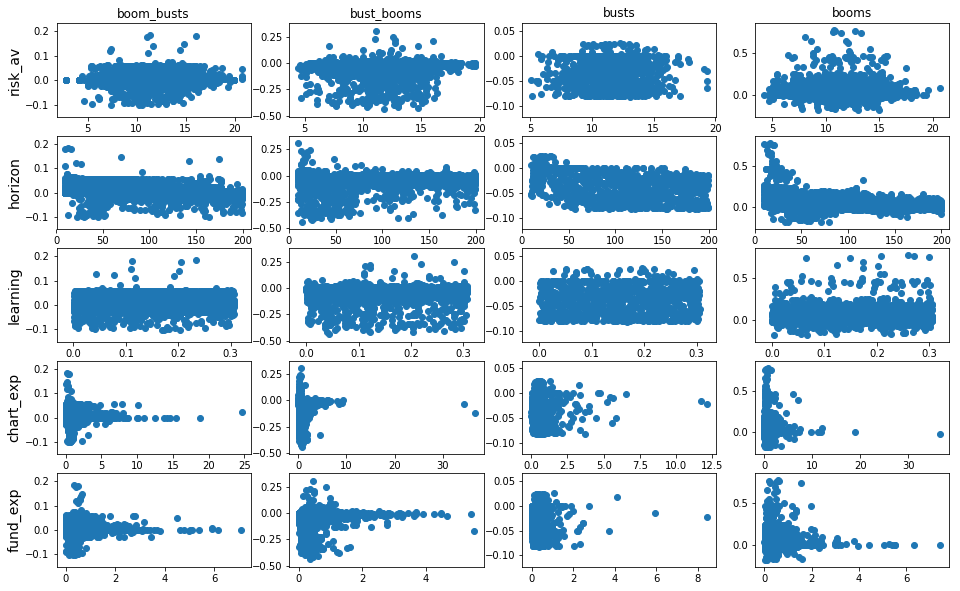

In [113]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), 
      (ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20)) = plt.subplots(5, 4, figsize=[16,10])

ax1.scatter(boom_busts['risk_av'], boom_busts['wealth_change'])
ax2.scatter(bust_booms['risk_av'], bust_booms['wealth_change'])
ax3.scatter(busts['risk_av'], busts['wealth_change'])
ax4.scatter(booms['risk_av'], booms['wealth_change'])
#axn1.scatter(no_bubble['magnitude'], no_bubble['gini_diff'])

ax5.scatter(boom_busts['horizon'], boom_busts['wealth_change'])
ax6.scatter(bust_booms['horizon'], bust_booms['wealth_change'])
ax7.scatter(busts['horizon'], busts['wealth_change'])
ax8.scatter(booms['horizon'], booms['wealth_change'])
#axn2.scatter(no_bubble['magnitude'], no_bubble['palma_diff'])

ax9.scatter(boom_busts['learning'], boom_busts['wealth_change'])
ax10.scatter(bust_booms['learning'], bust_booms['wealth_change'])
ax11.scatter(busts['learning'], busts['wealth_change'])
ax12.scatter(booms['learning'], booms['wealth_change'])
#axn3.scatter(no_bubble['magnitude'], no_bubble['twtw_diff'])

ax13.scatter(boom_busts['chart_exp'], boom_busts['wealth_change'])
ax14.scatter(bust_booms['chart_exp'], bust_booms['wealth_change'])
ax15.scatter(busts['chart_exp'], busts['wealth_change'])
ax16.scatter(booms['chart_exp'], booms['wealth_change'])
#axn2.scatter(no_bubble['magnitude'], no_bubble['palma_diff'])

ax17.scatter(boom_busts['fund_exp'], boom_busts['wealth_change'])
ax18.scatter(bust_booms['fund_exp'], bust_booms['wealth_change'])
ax19.scatter(busts['fund_exp'], busts['wealth_change'])
ax20.scatter(booms['fund_exp'], booms['wealth_change'])
#axn3.scatter(no_bubble['magnitude'], no_bubble['twtw_diff'])

ax1.set_title('boom_busts')
ax2.set_title('bust_booms')
ax3.set_title('busts')
ax4.set_title('booms')
#axn1.set_title('no_bubble')

ax1.set_ylabel('risk_av', fontsize=14)
ax5.set_ylabel('horizon', fontsize=14)
ax9.set_ylabel('learning', fontsize=14)
ax13.set_ylabel('chart_exp', fontsize=14)
ax17.set_ylabel('fund_exp', fontsize=14)

#TODO change layout

Then, for the different bubble types: boom-bust, bust-boom, bust & boom. 

## Regression alalyses:

Regression model:



In [114]:
reg1 = sm.OLS(endog=boom_busts['wealth_change'], exog=boom_busts[['const', 'risk_av', 'horizon', 'learning', 'chart_exp', 'fund_exp']], missing='drop').fit()
reg2 = sm.OLS(endog=bust_booms['wealth_change'], exog=bust_booms[['const', 'risk_av', 'horizon', 'learning', 'chart_exp', 'fund_exp']], missing='drop').fit()
reg3 = sm.OLS(endog=busts['wealth_change'], exog=busts[['const', 'risk_av', 'horizon', 'learning', 'chart_exp', 'fund_exp']], missing='drop').fit()
reg4 = sm.OLS(endog=booms['wealth_change'], exog=booms[['const', 'risk_av', 'horizon', 'learning', 'chart_exp', 'fund_exp']], missing='drop').fit()

In [115]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[reg1, reg2, reg3, reg4],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['boom-bust',
                                         'bust-boom',
                                         'busts', 'booms'],
                            info_dict=info_dict,
                            regressor_order=['const', 'risk_av', 'horizon', 'learning', 'chart_exp', 'fund_exp'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                           Table - OLS Regressions
                   boom-bust       bust-boom         busts         booms     
-----------------------------------------------------------------------------
const            0.0156***      -0.0456***       -0.0180***    0.1355***     
                 (0.0008)       (0.0035)         (0.0045)      (0.0079)      
risk_av          0.0000         0.0009***        0.0002        -0.0025***    
                 (0.0001)       (0.0003)         (0.0003)      (0.0006)      
horizon          -0.0001***     0.0000*          -0.0002***    -0.0006***    
                 (0.0000)       (0.0000)         (0.0000)      (0.0000)      
learning         0.0006         0.0130*          0.0134        0.0161        
                 (0.0016)       (0.0066)         (0.0085)      (0.0153)      
chart_exp        0.0004         -0.0016*         0.0060***     0.0012        
                 (0.0002)       (0.0008)         (0.0014)      (0.0016)      
fund_exp     

### 2 Compare ratio's of different groups before and after bubbles. 

# try randomly assigning properties

In [119]:
import random

In [168]:
share_f = 0.3
share_c = 0.5
share_r = 0.2
n_agents = 100

In [169]:
agents = [{'f': 0, 'c': 0, 'r': 0} for x in range(n_agents)]

In [170]:
# create 3 lists of expectation points:
f_points = int(share_f * 100 * n_agents)
c_points = int(share_c * 100 * n_agents)
r_points = int(share_r * 100 * n_agents)

In [181]:
# nieuwe aanpak, creeër array's of name en draw at random from them
strat_points = ['f' for f in range(f_points)] + ['c' for c in range(c_points)] + ['r' for r in range(r_points)]

In [182]:
random.shuffle(strat_points)

In [183]:
agent_points = np.array_split(strat_points, n_agents)

In [185]:
for agent in agent_points:
    f_exp_agent0 = list(agent).count('f') / float(len(agent))
    c_exp_agent0 = list(agent).count('c') / float(len(agent))
    r_exp_agent0 = list(agent).count('r') / float(len(agent))
    print(f_exp_agent0, c_exp_agent0, r_exp_agent0)

(0.26, 0.5, 0.24)
(0.31, 0.5, 0.19)
(0.37, 0.49, 0.14)
(0.3, 0.52, 0.18)
(0.27, 0.54, 0.19)
(0.34, 0.45, 0.21)
(0.3, 0.55, 0.15)
(0.3, 0.46, 0.24)
(0.27, 0.47, 0.26)
(0.19, 0.59, 0.22)
(0.27, 0.5, 0.23)
(0.26, 0.59, 0.15)
(0.32, 0.51, 0.17)
(0.28, 0.52, 0.2)
(0.28, 0.51, 0.21)
(0.36, 0.44, 0.2)
(0.4, 0.39, 0.21)
(0.27, 0.49, 0.24)
(0.2, 0.59, 0.21)
(0.28, 0.44, 0.28)
(0.31, 0.55, 0.14)
(0.32, 0.5, 0.18)
(0.28, 0.46, 0.26)
(0.32, 0.46, 0.22)
(0.36, 0.42, 0.22)
(0.33, 0.49, 0.18)
(0.29, 0.6, 0.11)
(0.31, 0.5, 0.19)
(0.32, 0.48, 0.2)
(0.25, 0.59, 0.16)
(0.29, 0.56, 0.15)
(0.27, 0.55, 0.18)
(0.35, 0.51, 0.14)
(0.25, 0.49, 0.26)
(0.36, 0.43, 0.21)
(0.33, 0.43, 0.24)
(0.33, 0.45, 0.22)
(0.28, 0.49, 0.23)
(0.32, 0.47, 0.21)
(0.28, 0.46, 0.26)
(0.22, 0.55, 0.23)
(0.29, 0.52, 0.19)
(0.34, 0.47, 0.19)
(0.31, 0.55, 0.14)
(0.28, 0.51, 0.21)
(0.3, 0.45, 0.25)
(0.29, 0.53, 0.18)
(0.41, 0.48, 0.11)
(0.28, 0.47, 0.25)
(0.29, 0.51, 0.2)
(0.31, 0.5, 0.19)
(0.38, 0.42, 0.2)
(0.22, 0.57, 0.21)
(0.34, 0.46

In [153]:
print(f_exp_agent0, c_exp_agent0, r_exp_agent0)
print(f_exp_agent0 + c_exp_agent0 + r_exp_agent0)

(0.36, 0.46, 0.18)
1.0
